# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [35]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [36]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    #lr=0.001
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [38]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import Parameter, ParameterVector

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

In [39]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [40]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [41]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [42]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [43]:
from qiskit.circuit.library.standard_gates import RXGate, RYGate, MCXGate

def incrementor(nq):
    qc = QuantumCircuit(nq)
    for i in range(nq,0,-1):
        if i == 1:
            qc.x(0)
        else:
            qc.append(MCXGate(i-1),range(i))
    return qc

def decrementor(nq):
    qc = QuantumCircuit(nq)
    for i in range(nq):
        if i == 0:
            qc.x(0)
        else:
            qc.append(MCXGate(i),range(i+1))
    return qc

In [44]:
num = 1
shift_num = 1
parameters_theta_right = ParameterVector('theta_r', length=(shift_num))
parameters_theta_left = ParameterVector('theta_l', length=(shift_num))
parameters_phi_right = ParameterVector('phi_r', length=(shift_num))
parameters_phi_left = ParameterVector('phi_l', length=(shift_num))
parameters_lambda_right = ParameterVector('lambda_r', length=(shift_num))
parameters_lambda_left = ParameterVector('lambda_l', length=(shift_num))

parameters_theta_left_pos = ParameterVector('theta_l_pos', length=(num))
parameters_theta_right_pos = ParameterVector('theta_r_pos', length=(num))
parameters_phi_left_pos = ParameterVector('phi_l_pos', length=(num))
parameters_phi_right_pos = ParameterVector('phi_r_pos', length=(num))
parameters_lambda_left_pos = ParameterVector('lambda_l_pos', length=(num))
parameters_lambda_right_pos = ParameterVector('lambda_r_pos', length=(num))

def multi_conditional_shift_operator_right(Num_CoinQubits, Num_PositionQubits):
    # Define your shift operator using trainable parameters
    shift_operator = QuantumCircuit(Num_CoinQubits + Num_PositionQubits, name='ShiftOperator')

    # Apply u gates 
    for i in range(Num_PositionQubits):
        shift_operator.u(parameters_theta_right[i], parameters_phi_right[i], parameters_lambda_right[i], i)
        
    return shift_operator

def multi_conditional_shift_operator_left(Num_CoinQubits, Num_PositionQubits):
    # Define your shift operator using trainable parameters
    shift_operator = QuantumCircuit(Num_CoinQubits + Num_PositionQubits, name='ShiftOperator')

    # Apply u gates
    for i in range(Num_PositionQubits):
        shift_operator.u(parameters_theta_left[i], parameters_phi_left[i], parameters_lambda_left[i], i)

    return shift_operator


def QW_with_multicoin(Num_CoinQubits, Num_PositionQubits):
    qr_x = QuantumRegister(Num_PositionQubits, name="x")
    qr_c = QuantumRegister(Num_CoinQubits, name="c")
    #cr = ClassicalRegister(Num_PositionQubits, name="cbits")
    circ = QuantumCircuit(qr_x, qr_c)

    shift_right = multi_conditional_shift_operator_right(Num_CoinQubits, Num_PositionQubits)
    shift_left = multi_conditional_shift_operator_left(Num_CoinQubits, Num_PositionQubits)
    # Initialize coin qubits with trainable parameters
    
    # Full entanglement of coin qubits using u gate
    for i in range(2, Num_CoinQubits+1):
        circ.u(parameters_theta_right_pos[0], parameters_phi_right_pos[0], parameters_lambda_right_pos[0], i)
    
    for i in range(1, Num_CoinQubits):
        circ.u(parameters_theta_right_pos[0], parameters_phi_right_pos[0], parameters_lambda_right_pos[0], i)
        for j in range(i):
            circ.cx(qr_c[i], qr_c[j])
        circ.u(parameters_theta_right_pos[0], parameters_phi_right_pos[0], parameters_lambda_right_pos[0], i)            

    for i in range(2, Num_CoinQubits+1):
        circ.u(parameters_theta_right_pos[0], parameters_phi_right_pos[0], parameters_lambda_right_pos[0], i)


    circ.barrier()

    # Apply S+
    circ.append(shift_right, range(Num_CoinQubits + Num_PositionQubits))

    circ.barrier()

    # Update coin qubits with new parameters
    for i in range(2, Num_CoinQubits+1):
        circ.u(parameters_theta_left_pos[0], parameters_phi_left_pos[0], parameters_lambda_left_pos[0], i)
    
    for i in range(1, Num_CoinQubits):
        circ.u(parameters_theta_left_pos[0], parameters_phi_left_pos[0], parameters_lambda_left_pos[0], i)
        for j in range(i):
            circ.cx(qr_c[i], qr_c[j])
        circ.u(parameters_theta_left_pos[0], parameters_phi_left_pos[0], parameters_lambda_left_pos[0], i)
        
    for i in range(2, Num_CoinQubits+1):
        circ.u(parameters_theta_left_pos[0], parameters_phi_left_pos[0], parameters_lambda_left_pos[0], i)

            
    circ.barrier()

    # Apply S-
    circ.append(shift_left, range(Num_CoinQubits + Num_PositionQubits))

    #circ.measure(qr_x, cr)
    
    # Only return the classical register
    return circ

In [45]:
# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=3
def create_qnn():
    #feature_map = ZFeatureMap(nq, reps=2)
    feature_map = QW_with_multicoin(Num_CoinQubits=2, Num_PositionQubits=1)
    ansatz = RealAmplitudes(1, reps=2)
    qc = QuantumCircuit(nq)
    # Only compose the quantum circuit quantum register
    qc.compose(feature_map, inplace=True)
    # Place ansatz on the quantum register q0 to q1
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=[
            parameters_theta_right,
            parameters_phi_right,
            parameters_lambda_right,
            parameters_theta_left,
            parameters_phi_left,
            parameters_lambda_left,
            parameters_theta_left_pos,
            parameters_theta_right_pos,
            parameters_phi_left_pos,
            parameters_phi_right_pos,
            parameters_lambda_left_pos,
            parameters_lambda_right_pos,
        ],
        weight_params=ansatz.parameters,
        input_gradients=True,
        output_shape=0,
    )
    
    return qnn

qnn = create_qnn()

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


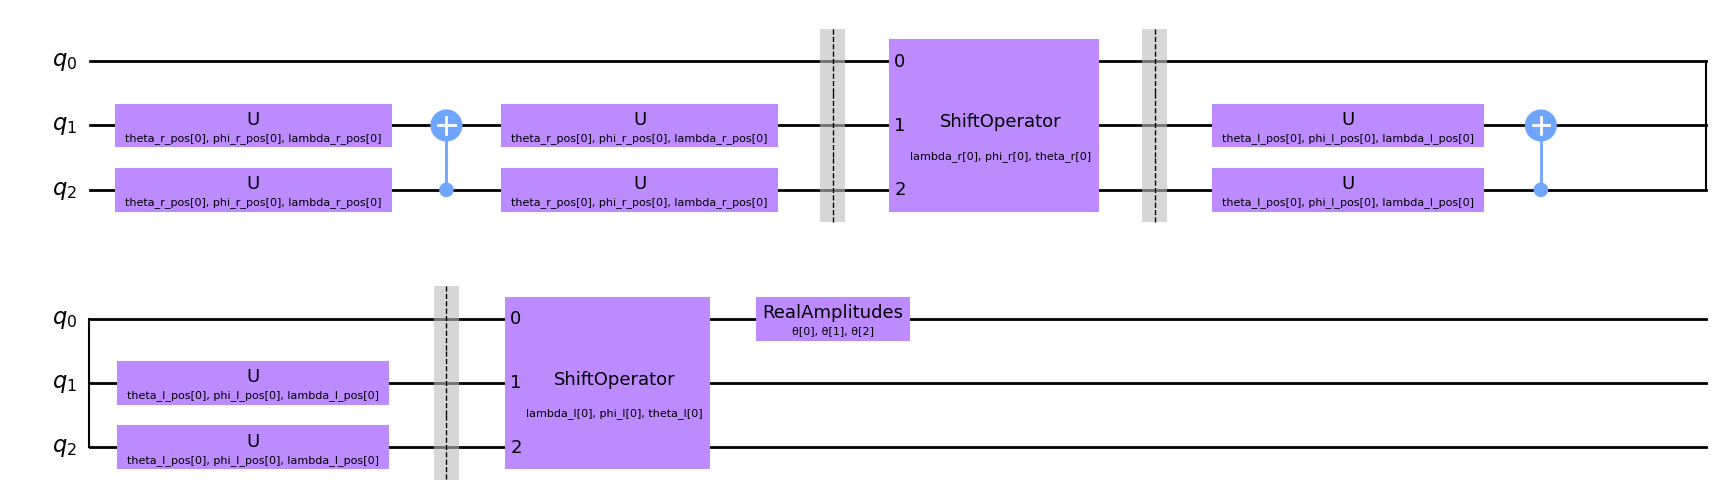

In [46]:
#feature_map = ZFeatureMap(nq, reps=2)
feature_map = QW_with_multicoin(Num_CoinQubits=2, Num_PositionQubits=1)
ansatz = RealAmplitudes(1, reps=2)
qc = QuantumCircuit(nq)
# Only compose the quantum circuit quantum register
qc.compose(feature_map, inplace=True)
# Place ansatz on the quantum register q0 to q1
qc.compose(ansatz, inplace=True)
qc.draw('mpl')

In [47]:
class QuantumCustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.fc = nn.Linear(512, 12)    
        # Continue to write your own cnn layers
        #self.relu = nn.ReLU()
        #self.conv1d = nn.Conv1d(512, 256, kernel_size=3, padding=1)

        self.qnn = TorchConnector(qnn)
        #self.fc2 = nn.Linear(pow(2, nq), 2)

        # Remove fully connected layer and last two blocks
        self.model.fc = nn.Identity()
        self.model.layer4 = nn.Identity()
        self.model.layer3 = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        #x = self.fc2(x)

        return x

In [48]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [49]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    #check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    torch.save(model.state_dict(), OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    qnn5 = create_qnn()
    model5 = QuantumCustomResNext(qnn5)
    model5.load_state_dict(torch.load("model4.pt"))
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [50]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()


In [51]:
if __name__ == '__main__':
    main(0)

========== training ==========
========== training ==========
========== training ==========


Epoch: [1][1/192] Data 0.337 (0.337) Elapsed 0m 6s (remain 19m 37s) Loss: 1.6625(1.6625) Grad: 35.0545  
Epoch: [1][101/192] Data 0.000 (0.004) Elapsed 8m 42s (remain 7m 51s) Loss: 1.4184(1.5469) Grad: 5.6416  
Epoch: [1][192/192] Data 0.000 (0.002) Elapsed 16m 35s (remain 0m 0s) Loss: 1.5177(1.5119) Grad: 5.8889  
EVAL: [1/49] Data 0.161 (0.161) Elapsed 0m 0s (remain 0m 13s) Loss: 1.4802(1.4802) 


Epoch 1 - avg_train_loss: 1.5119  avg_val_loss: 1.4699  time: 1001s
Epoch 1 - avg_train_loss: 1.5119  avg_val_loss: 1.4699  time: 1001s
Epoch 1 - avg_train_loss: 1.5119  avg_val_loss: 1.4699  time: 1001s
Epoch 1 - Accuracy: 0.834850455136541
Epoch 1 - Accuracy: 0.834850455136541
Epoch 1 - Accuracy: 0.834850455136541
Epoch 1 - Save Best Score: 0.8349 Model
Epoch 1 - Save Best Score: 0.8349 Model
Epoch 1 - Save Best Score: 0.8349 Model


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 4s (remain 0m 0s) Loss: 1.6663(1.4699) 
Epoch: [2][1/192] Data 0.272 (0.272) Elapsed 0m 5s (remain 17m 17s) Loss: 1.4483(1.4483) Grad: 10.3161  
Epoch: [2][101/192] Data 0.000 (0.003) Elapsed 8m 39s (remain 7m 48s) Loss: 1.3798(1.4522) Grad: 6.6155  
Epoch: [2][192/192] Data 0.000 (0.002) Elapsed 16m 26s (remain 0m 0s) Loss: 1.4882(1.4458) Grad: 2.7673  
EVAL: [1/49] Data 0.126 (0.126) Elapsed 0m 0s (remain 0m 11s) Loss: 1.4561(1.4561) 


Epoch 2 - avg_train_loss: 1.4458  avg_val_loss: 1.4509  time: 990s
Epoch 2 - avg_train_loss: 1.4458  avg_val_loss: 1.4509  time: 990s
Epoch 2 - avg_train_loss: 1.4458  avg_val_loss: 1.4509  time: 990s
Epoch 2 - Accuracy: 0.8589076723016905
Epoch 2 - Accuracy: 0.8589076723016905
Epoch 2 - Accuracy: 0.8589076723016905
Epoch 2 - Save Best Score: 0.8589 Model
Epoch 2 - Save Best Score: 0.8589 Model
Epoch 2 - Save Best Score: 0.8589 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.6937(1.4509) 
Epoch: [3][1/192] Data 0.270 (0.270) Elapsed 0m 5s (remain 17m 43s) Loss: 1.4236(1.4236) Grad: 10.4607  
Epoch: [3][101/192] Data 0.000 (0.003) Elapsed 8m 40s (remain 7m 48s) Loss: 1.3522(1.4297) Grad: 6.6661  
Epoch: [3][192/192] Data 0.000 (0.002) Elapsed 16m 27s (remain 0m 0s) Loss: 1.4726(1.4246) Grad: 3.3422  
EVAL: [1/49] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 12s) Loss: 1.4194(1.4194) 


Epoch 3 - avg_train_loss: 1.4246  avg_val_loss: 1.4336  time: 991s
Epoch 3 - avg_train_loss: 1.4246  avg_val_loss: 1.4336  time: 991s
Epoch 3 - avg_train_loss: 1.4246  avg_val_loss: 1.4336  time: 991s
Epoch 3 - Accuracy: 0.8530559167750326
Epoch 3 - Accuracy: 0.8530559167750326
Epoch 3 - Accuracy: 0.8530559167750326


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7427(1.4336) 
Epoch: [4][1/192] Data 0.310 (0.310) Elapsed 0m 5s (remain 18m 15s) Loss: 1.4233(1.4233) Grad: 12.6194  
Epoch: [4][101/192] Data 0.000 (0.003) Elapsed 8m 39s (remain 7m 48s) Loss: 1.3464(1.4162) Grad: 5.2202  
Epoch: [4][192/192] Data 0.000 (0.002) Elapsed 16m 35s (remain 0m 0s) Loss: 1.4605(1.4131) Grad: 2.8232  
EVAL: [1/49] Data 0.153 (0.153) Elapsed 0m 0s (remain 0m 14s) Loss: 1.4226(1.4226) 


Epoch 4 - avg_train_loss: 1.4131  avg_val_loss: 1.4314  time: 1000s
Epoch 4 - avg_train_loss: 1.4131  avg_val_loss: 1.4314  time: 1000s
Epoch 4 - avg_train_loss: 1.4131  avg_val_loss: 1.4314  time: 1000s
Epoch 4 - Accuracy: 0.8621586475942783
Epoch 4 - Accuracy: 0.8621586475942783
Epoch 4 - Accuracy: 0.8621586475942783
Epoch 4 - Save Best Score: 0.8622 Model
Epoch 4 - Save Best Score: 0.8622 Model
Epoch 4 - Save Best Score: 0.8622 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: 1.7299(1.4314) 
Epoch: [5][1/192] Data 0.348 (0.348) Elapsed 0m 7s (remain 24m 19s) Loss: 1.4191(1.4191) Grad: 13.7797  
Epoch: [5][101/192] Data 0.000 (0.004) Elapsed 9m 46s (remain 8m 48s) Loss: 1.3369(1.4067) Grad: 3.9629  
Epoch: [5][192/192] Data 0.000 (0.002) Elapsed 18m 17s (remain 0m 0s) Loss: 1.4826(1.4034) Grad: 1.9564  
EVAL: [1/49] Data 0.152 (0.152) Elapsed 0m 0s (remain 0m 13s) Loss: 1.4114(1.4114) 


Epoch 5 - avg_train_loss: 1.4034  avg_val_loss: 1.4190  time: 1103s
Epoch 5 - avg_train_loss: 1.4034  avg_val_loss: 1.4190  time: 1103s
Epoch 5 - avg_train_loss: 1.4034  avg_val_loss: 1.4190  time: 1103s
Epoch 5 - Accuracy: 0.871261378413524
Epoch 5 - Accuracy: 0.871261378413524
Epoch 5 - Accuracy: 0.871261378413524
Epoch 5 - Save Best Score: 0.8713 Model
Epoch 5 - Save Best Score: 0.8713 Model
Epoch 5 - Save Best Score: 0.8713 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: 1.7294(1.4190) 
Epoch: [6][1/192] Data 0.325 (0.325) Elapsed 0m 6s (remain 21m 40s) Loss: 1.4083(1.4083) Grad: 13.5004  
Epoch: [6][101/192] Data 0.000 (0.003) Elapsed 9m 13s (remain 8m 18s) Loss: 1.3445(1.4006) Grad: 4.3288  
Epoch: [6][192/192] Data 0.000 (0.002) Elapsed 16m 57s (remain 0m 0s) Loss: 1.4551(1.3973) Grad: 2.9101  
EVAL: [1/49] Data 0.122 (0.122) Elapsed 0m 0s (remain 0m 11s) Loss: 1.4142(1.4142) 


Epoch 6 - avg_train_loss: 1.3973  avg_val_loss: 1.4247  time: 1021s
Epoch 6 - avg_train_loss: 1.3973  avg_val_loss: 1.4247  time: 1021s
Epoch 6 - avg_train_loss: 1.3973  avg_val_loss: 1.4247  time: 1021s
Epoch 6 - Accuracy: 0.8699609882964889
Epoch 6 - Accuracy: 0.8699609882964889
Epoch 6 - Accuracy: 0.8699609882964889


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7117(1.4247) 
Epoch: [7][1/192] Data 0.239 (0.239) Elapsed 0m 5s (remain 18m 31s) Loss: 1.3990(1.3990) Grad: 12.9604  
Epoch: [7][101/192] Data 0.000 (0.003) Elapsed 8m 38s (remain 7m 46s) Loss: 1.3309(1.3948) Grad: 4.0775  
Epoch: [7][192/192] Data 0.000 (0.001) Elapsed 16m 22s (remain 0m 0s) Loss: 1.4636(1.3918) Grad: 3.2339  
EVAL: [1/49] Data 0.111 (0.111) Elapsed 0m 0s (remain 0m 10s) Loss: 1.4091(1.4091) 


Epoch 7 - avg_train_loss: 1.3918  avg_val_loss: 1.4216  time: 986s
Epoch 7 - avg_train_loss: 1.3918  avg_val_loss: 1.4216  time: 986s
Epoch 7 - avg_train_loss: 1.3918  avg_val_loss: 1.4216  time: 986s
Epoch 7 - Accuracy: 0.8706111833550065
Epoch 7 - Accuracy: 0.8706111833550065
Epoch 7 - Accuracy: 0.8706111833550065


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: 1.6858(1.4216) 
Epoch: [8][1/192] Data 0.294 (0.294) Elapsed 0m 5s (remain 18m 57s) Loss: 1.3886(1.3886) Grad: 13.3887  
Epoch: [8][101/192] Data 0.000 (0.003) Elapsed 8m 36s (remain 7m 45s) Loss: 1.3328(1.3925) Grad: 3.0949  
Epoch: [8][192/192] Data 0.000 (0.002) Elapsed 16m 18s (remain 0m 0s) Loss: 1.4731(1.3892) Grad: 2.3897  
EVAL: [1/49] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 11s) Loss: 1.4021(1.4021) 


Epoch 8 - avg_train_loss: 1.3892  avg_val_loss: 1.4211  time: 982s
Epoch 8 - avg_train_loss: 1.3892  avg_val_loss: 1.4211  time: 982s
Epoch 8 - avg_train_loss: 1.3892  avg_val_loss: 1.4211  time: 982s
Epoch 8 - Accuracy: 0.8725617685305592
Epoch 8 - Accuracy: 0.8725617685305592
Epoch 8 - Accuracy: 0.8725617685305592
Epoch 8 - Save Best Score: 0.8726 Model
Epoch 8 - Save Best Score: 0.8726 Model
Epoch 8 - Save Best Score: 0.8726 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7125(1.4211) 
Epoch: [9][1/192] Data 0.247 (0.247) Elapsed 0m 5s (remain 17m 20s) Loss: 1.3854(1.3854) Grad: 12.2468  
Epoch: [9][101/192] Data 0.000 (0.003) Elapsed 8m 36s (remain 7m 45s) Loss: 1.3369(1.3877) Grad: 2.7813  
Epoch: [9][192/192] Data 0.000 (0.001) Elapsed 16m 24s (remain 0m 0s) Loss: 1.4513(1.3861) Grad: 4.3682  
EVAL: [1/49] Data 0.121 (0.121) Elapsed 0m 0s (remain 0m 10s) Loss: 1.4009(1.4009) 


Epoch 9 - avg_train_loss: 1.3861  avg_val_loss: 1.4210  time: 988s
Epoch 9 - avg_train_loss: 1.3861  avg_val_loss: 1.4210  time: 988s
Epoch 9 - avg_train_loss: 1.3861  avg_val_loss: 1.4210  time: 988s
Epoch 9 - Accuracy: 0.8706111833550065
Epoch 9 - Accuracy: 0.8706111833550065
Epoch 9 - Accuracy: 0.8706111833550065


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7212(1.4210) 
Epoch: [10][1/192] Data 0.223 (0.223) Elapsed 0m 5s (remain 17m 58s) Loss: 1.3764(1.3764) Grad: 10.5629  
Epoch: [10][101/192] Data 0.000 (0.002) Elapsed 8m 39s (remain 7m 48s) Loss: 1.3374(1.3880) Grad: 2.5684  
Epoch: [10][192/192] Data 0.000 (0.001) Elapsed 16m 23s (remain 0m 0s) Loss: 1.4727(1.3848) Grad: 3.1140  
EVAL: [1/49] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 10s) Loss: 1.4003(1.4003) 


Epoch 10 - avg_train_loss: 1.3848  avg_val_loss: 1.4191  time: 987s
Epoch 10 - avg_train_loss: 1.3848  avg_val_loss: 1.4191  time: 987s
Epoch 10 - avg_train_loss: 1.3848  avg_val_loss: 1.4191  time: 987s
Epoch 10 - Accuracy: 0.8758127438231469
Epoch 10 - Accuracy: 0.8758127438231469
Epoch 10 - Accuracy: 0.8758127438231469
Epoch 10 - Save Best Score: 0.8758 Model
Epoch 10 - Save Best Score: 0.8758 Model
Epoch 10 - Save Best Score: 0.8758 Model
========== CV ==========
========== CV ==========
========== CV ==========


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.7142(1.4191) 


KeyError: 'preds'